# Package Import (Must Run)

In [116]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
import string
import re
from sklearn import metrics
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Constants and Helper Functions (Must Run)¶

In [87]:
#-----------------------------Constants-----------------------------------#
k = 1000

COMPUTER_TECHNOLOGY = 0

RECREATIONAL_ACTIVITY = 1

# index of the last computer technology data group in variable 'categories'
LAST_COMPUTER_TECHNOLOGY_INDEX = 3 


#-----------------------------Helper Functions----------------------------#

def tokenizer_stem(text):
    # Convert each punctuation character to empty character.
    punc_remove_map = text.maketrans('', '', string.punctuation)
    text_no_punc = text.translate(punc_remove_map)
    
    # remove non-ascii characters
    ascii_text_no_punc = "".join(ch for ch in text_no_punc if ord(ch) < 128) 
    
    # Convert words that share the same stem to the stem
    tokens = ascii_text_no_punc.split()
    return tokens
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(n) for n in tokens if not n.isdigit()]
    #return stemmed_tokens



def get_target_values(target_array):
    target_values = []
    for n in range(target_array.shape[0]):
        if target_array[n] <= LAST_COMPUTER_TECHNOLOGY_INDEX:
            target_values.append(COMPUTER_TECHNOLOGY)
        else:
            target_values.append(RECREATIONAL_ACTIVITY)
    return np.array(target_values)



def get_kmeans_results (features, true_labels, num_clusters):
    
    predicted_labels = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(features)
    
    #print("contingency matrix for r =", r)
    
    contingency_matrix = confusion_matrix(true_labels, predicted_labels)
 
    scores = []
    scores.append(metrics.homogeneity_score(true_labels, predicted_labels))
    scores.append(metrics.completeness_score(true_labels, predicted_labels))
    scores.append(metrics.v_measure_score(true_labels, predicted_labels))
    scores.append(metrics.adjusted_rand_score(true_labels, predicted_labels))
    scores.append(metrics.adjusted_mutual_info_score(true_labels, predicted_labels))
    
    return contingency_matrix, scores
    
def two_dimensional_clustering_plot (data, kmeans):
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    for i in range(data.shape[1]):
        ds = data[np.where(labels==i)]
        plt.plot(ds[:, 0], ds[:, 1], 'o')
        lines = plt.plot(centers[i, 0], centers[i, 1], marker='x', color='k')
        plt.setp(lines, ms=15.0)
        plt.setp(lines, mew=2.0)
    
    
    plt.show()



# Classification Preparation (Must Run)

In [76]:
# Extract datasets
categories = ['comp.graphics',
              'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware',
              'rec.autos',
              'rec.motorcycles',
              'rec.sport.baseball',
              'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

# Set labels for binary classifiers
targets = get_target_values(dataset.target)


# Initialize term count vectorizers
count_vectorizer = CountVectorizer(
    analyzer = 'word',
    stop_words = ENGLISH_STOP_WORDS,
    min_df = 3
)

word_count = count_vectorizer.fit_transform(dataset.data)

# TFIDF transformer
tfidf_transformer = TfidfTransformer()
# Compute tfidf Matrices
tfidf = tfidf_transformer.fit_transform(word_count)

# Problem 1

In [77]:
print("Dimensions of TF-IDF matrix: "+ str(tfidf.shape))

Dimensions of TF-IDF matrix: (7882, 27768)


# Problem 2

In [80]:
#(a)
kmeans = KMeans(n_clusters=2, random_state=42).fit(tfidf)
confusionmatrix = confusion_matrix(targets, kmeans.labels_, labels = [COMPUTER_TECHNOLOGY, RECREATIONAL_ACTIVITY])
print("contingency matrix:")
print(confusionmatrix)

contingency matrix:
[[   4 3899]
 [1717 2262]]


In [82]:
#(b)
print("Homogeneity: %f" % metrics.homogeneity_score(targets, kmeans.labels_))
print("Completeness: %f" % metrics.completeness_score(targets, kmeans.labels_))
print("V-measure: %f" % metrics.v_measure_score(targets, kmeans.labels_))
print("Adjusted Rand Score: %f" % metrics.adjusted_rand_score(targets, kmeans.labels_))
print("Adjusted Mutual Info Score: %f" % metrics.adjusted_mutual_info_score(targets, kmeans.labels_))

Homogeneity: 0.253413
Completeness: 0.334677
V-measure: 0.288430
Adjusted Rand Score: 0.180546
Adjusted Mutual Info Score: 0.253345


# Problem 3

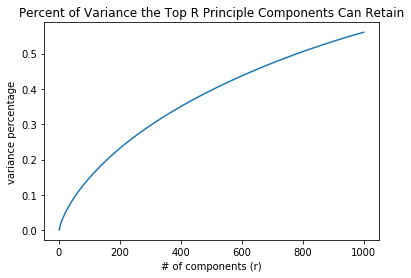

In [84]:
# (a), plot of the percent of variance the toprprinciple components canretain v.s r
lsa_model = TruncatedSVD(n_components=1000, random_state=42)
tfidf_lsa = lsa_model.fit(tfidf)
variance_ratio = tfidf_lsa.explained_variance_ratio_

#plotting variance curve
plt.plot(range(1, 1001), np.cumsum(variance_ratio))
plt.xlabel('# of components (r)')
plt.ylabel('variance percentage')
plt.title('Percent of Variance the Top R Principle Components Can Retain')
plt.show()

contingency matrix when r = 1
[[2195 1708]
 [2318 1661]]
contingency matrix when r = 2
[[3691  212]
 [ 436 3543]]
contingency matrix when r = 3
[[3874   29]
 [1492 2487]]
contingency matrix when r = 5
[[   5 3898]
 [1543 2436]]
contingency matrix when r = 10
[[   3 3900]
 [1607 2372]]
contingency matrix when r = 20
[[3900    3]
 [2364 1615]]
contingency matrix when r = 50
[[3899    4]
 [2325 1654]]
contingency matrix when r = 100
[[   3 3900]
 [1670 2309]]
contingency matrix when r = 300
[[   3 3900]
 [1643 2336]]


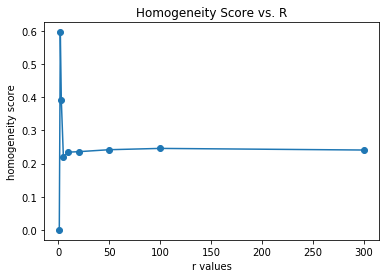

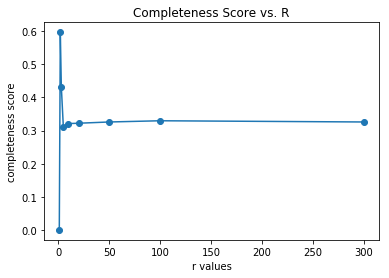

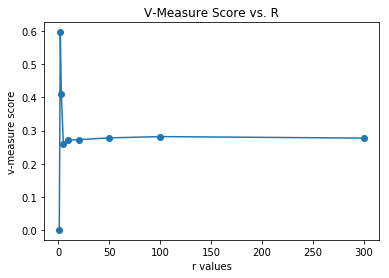

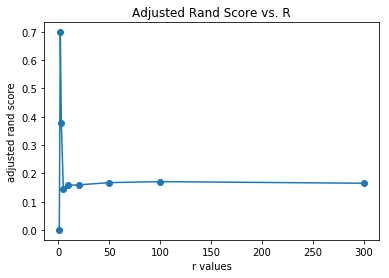

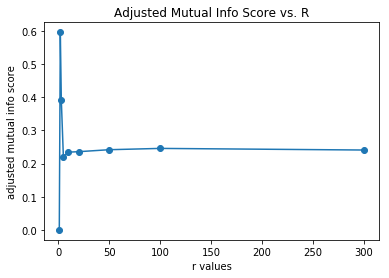

In [93]:
# (b) find best r using SVD

r_list = [1, 2, 3, 5, 10, 20, 50, 100, 300]
homogeneity = []
completeness = []
v_measure = []
adjusted_rand = []
adjusted_mutual_info = []
for r in r_list:
    features = TruncatedSVD(n_components=r, random_state=42).fit_transform(tfidf)
    contingency_matrix, scores = get_kmeans_results (features, targets, 2)
    print("contingency matrix when r =", r)
    print(contingency_matrix)
    homogeneity.append(scores[0])
    completeness.append(scores[1])
    v_measure.append(scores[2])
    adjusted_rand.append(scores[3])
    adjusted_mutual_info.append(scores[4])
    
plt.plot(r_list, homogeneity, '-o')
plt.xlabel('r values')
plt.ylabel('homogeneity score')
plt.title('Homogeneity Score vs. R')
plt.show()

plt.plot(r_list, completeness, '-o')
plt.xlabel('r values')
plt.ylabel('completeness score')
plt.title('Completeness Score vs. R')
plt.show()

plt.plot(r_list, v_measure, '-o')
plt.xlabel('r values')
plt.ylabel('v-measure score')
plt.title('V-Measure Score vs. R')
plt.show()

plt.plot(r_list, adjusted_rand, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score vs. R')
plt.show()

plt.plot(r_list, adjusted_mutual_info, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted mutual info score')
plt.title('Adjusted Mutual Info Score vs. R')
plt.show()


In [95]:
# (b) find best r using NMF
r_list = [1,2,3,5,10,20,50,100,300]
homogeneity = []
completeness = []
v_measure = []
adjusted_rand = []
adjusted_mutual_info = []
for r in r_list:
    features = NMF(n_components=r, random_state=42).fit_transform(tfidf)
    contingency_matrix, scores = get_kmeans_results (features, targets, 2)
    print("contingency matrix when r =", r)
    print(contingency_matrix)
    homogeneity.append(scores[0])
    completeness.append(scores[1])
    v_measure.append(scores[2])
    adjusted_rand.append(scores[3])
    adjusted_mutual_info.append(scores[4])
    
plt.plot(r_list, homogeneity, '-o')
plt.xlabel('r values')
plt.ylabel('homogeneity score')
plt.title('Homogeneity Score vs. R')
plt.show()

plt.plot(r_list, completeness, '-o')
plt.xlabel('r values')
plt.ylabel('completeness score')
plt.title('Completeness Score vs. R')
plt.show()

plt.plot(r_list, v_measure, '-o')
plt.xlabel('r values')
plt.ylabel('v-measure score')
plt.title('V-Measure Score vs. R')
plt.show()

plt.plot(r_list, adjusted_rand, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted rand score')
plt.title('Adjusted Rand Score vs. R')
plt.show()

plt.plot(r_list, adjusted_mutual_info, '-o')
plt.xlabel('r values')
plt.ylabel('adjusted mutual info score')
plt.title('Adjusted Mutual Info Score vs. R')
plt.show()

KeyboardInterrupt: 

# Problem 4

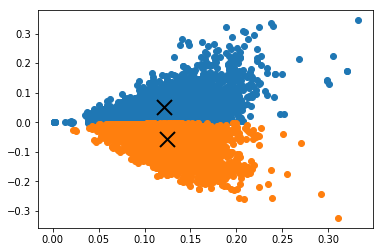

(7882,) (7882,) (7882, 2)
[[3691  212]
 [ 436 3543]]


In [103]:
#(a) using best result in SVD which is r = 2 to visualize the clustering results 
best_lsa_data = TruncatedSVD(n_components=2, random_state=42).fit_transform(tfidf)
kmeans_best_lsa = KMeans(n_clusters=2, random_state=42).fit(best_lsa_data)
two_dimensional_clustering_plot (best_lsa_data, kmeans_best_lsa)
confusionmatrix = confusion_matrix(targets, kmeans_best_lsa.labels_)
print(confusionmatrix)

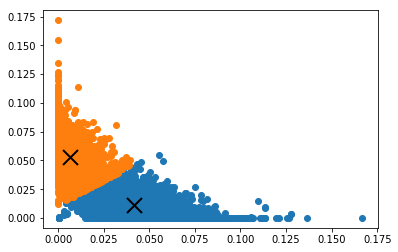

[[3594  309]
 [ 158 3821]]


In [104]:
#(a) using best result in NMF which is r = 2 to visualize the clustering results
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf)
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

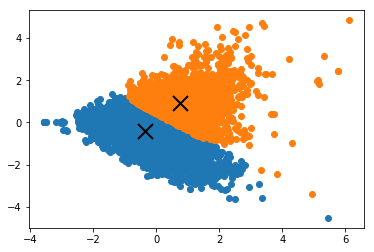

[[1705 2198]
 [3733  246]]


In [117]:
# (b) normalized features, SVD where r = 2
lsa = TruncatedSVD(n_components=2, random_state=42)
best_lsa_data = lsa.fit_transform(tfidf)

best_lsa_data = StandardScaler().fit_transform(best_lsa_data)

kmeans_best_lsa = KMeans(n_clusters=2, random_state=42).fit(best_lsa_data)
two_dimensional_clustering_plot (best_lsa_data, kmeans_best_lsa)
confusionmatrix = confusion_matrix(targets, kmeans_best_lsa.labels_)
print(confusionmatrix)

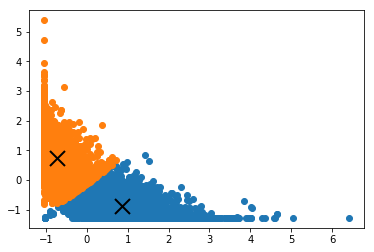

[[3534  369]
 [ 106 3873]]


In [118]:
# (b) normalized features, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
best_nmf_data = StandardScaler().fit_transform(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot(best_nmf_data, kmeans_best_nmf)
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

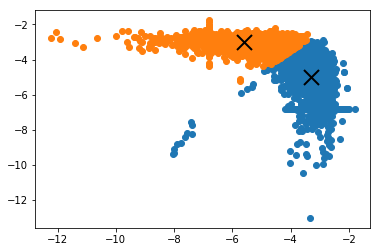

[[3701  202]
 [ 189 3790]]


In [168]:
# (b) log transformation, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)

for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.00111

best_nmf_data = np.log(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf)
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

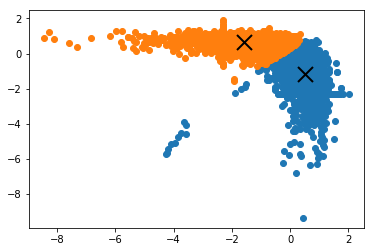

[[3671  232]
 [ 170 3809]]


In [204]:
# (b) normalized features -> log transformation, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
best_nmf_data = StandardScaler(with_mean=False).fit_transform(best_nmf_data)


for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.1

best_nmf_data = np.log(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf)
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)

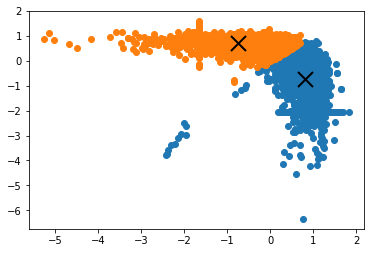

[[3656  247]
 [ 153 3826]]


In [188]:
# (b)  log transformation -> normalized features, NMF where r = 2
nmf = NMF(n_components=2, random_state = 42)
best_nmf_data = nmf.fit_transform(tfidf)
for x in np.nditer(best_nmf_data, op_flags=['readwrite']):
    if x == 0:
        x[...] = x + 0.001

best_nmf_data = np.log(best_nmf_data )
best_nmf_data = StandardScaler().fit_transform(best_nmf_data)
kmeans_best_nmf = KMeans(n_clusters=2, random_state=42).fit(best_nmf_data)
two_dimensional_clustering_plot (best_nmf_data, kmeans_best_nmf)
confusionmatrix = confusion_matrix(targets, kmeans_best_nmf.labels_)
print(confusionmatrix)